## Logistic regression & Understanding which factors influence your admission result

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np

df = pd.read_csv("Data Mining Project/admissions_processed.csv", low_memory=False)
rank_cols = ["cs_rank", "eng_rank", "mba_rank", "gen_rank"]
for col in rank_cols:
    if col in df.columns:
     
        df[col] = df[col].replace(9999, np.nan)
        df[f"{col}_missing"] = df[col].isna().astype(int)


y = df["admission_result"]


drop_cols = [
    "admission_result",
    "student_name",
    "student_id",
    "id",
    "gpa",
    "gpa_scale",
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])


if "application_status" in X.columns:
    X = X.drop(columns=["application_status"])

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = [c for c in X.columns if c not in numeric_features]

X[categorical_features] = X[categorical_features].astype(str)

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1,
    solver="lbfgs"
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("log_reg", log_reg)
])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

coeffs = model.named_steps["log_reg"].coef_[0]

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coeffs,
    "odds_ratio": np.exp(coeffs)
})

coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print("\n=== Feature importance (Logistic Regression) ===")
print(coef_df[["feature", "coef", "odds_ratio"]].head(50))


Numeric features: ['application_year', 'gpa_normalized', 'gpa_missing', 'undergrad_missing', 'toefl', 'ielts', 'english_test_normalized', 'english_missing', 'gre_total', 'gre_verbal', 'gre_quant', 'gre_awa', 'work_experience', 'relevant_work_experience', 'internship_experience', 'publications', 'scholarship_amount', 'cs_rank', 'cs_rank_missing', 'eng_rank', 'eng_rank_missing', 'mba_rank', 'mba_rank_missing', 'gen_rank', 'gen_rank_missing', 'major_alignment', 'total_experience', 'has_publications', 'is_fall_term', 'academic_alignment_score', 'composite_academic_score', 'student_type_encoded', 'has_scholarship_encoded', 'application_term_encoded']
Categorical features: ['student_type', 'university_name', 'university_name_stripped', 'course_name', 'credential', 'credential_standardized', 'categorical_course_name', 'target_degree', 'application_term', 'undergrad_major', 'ug_major_bucket', 'undergrad_university', 'undergrad_canonical', 'undergrad_canonical_stripped', 'gre_missing', 'has_sch

Logistic Regression AUC (train): 0.856
Logistic Regression AUC (test):  0.830


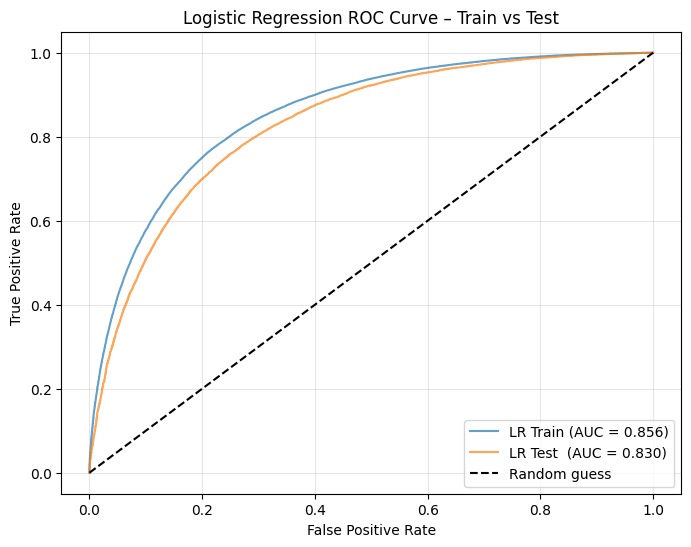

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_lr_train = model.predict_proba(X_train)[:, 1]
y_proba_lr_test  = model.predict_proba(X_test)[:, 1]

fpr_lr_train, tpr_lr_train, _ = roc_curve(y_train, y_proba_lr_train)
fpr_lr_test,  tpr_lr_test,  _ = roc_curve(y_test,  y_proba_lr_test)

auc_lr_train = roc_auc_score(y_train, y_proba_lr_train)
auc_lr_test  = roc_auc_score(y_test,  y_proba_lr_test)

print(f"Logistic Regression AUC (train): {auc_lr_train:.3f}")
print(f"Logistic Regression AUC (test):  {auc_lr_test:.3f}")
plt.figure(figsize=(8, 6))

plt.plot(fpr_lr_train, tpr_lr_train,
         label=f"LR Train (AUC = {auc_lr_train:.3f})", alpha=0.7)
plt.plot(fpr_lr_test,  tpr_lr_test,
         label=f"LR Test  (AUC = {auc_lr_test:.3f})",  alpha=0.7)

plt.plot([0, 1], [0, 1], "k--", label="Random guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve – Train vs Test")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


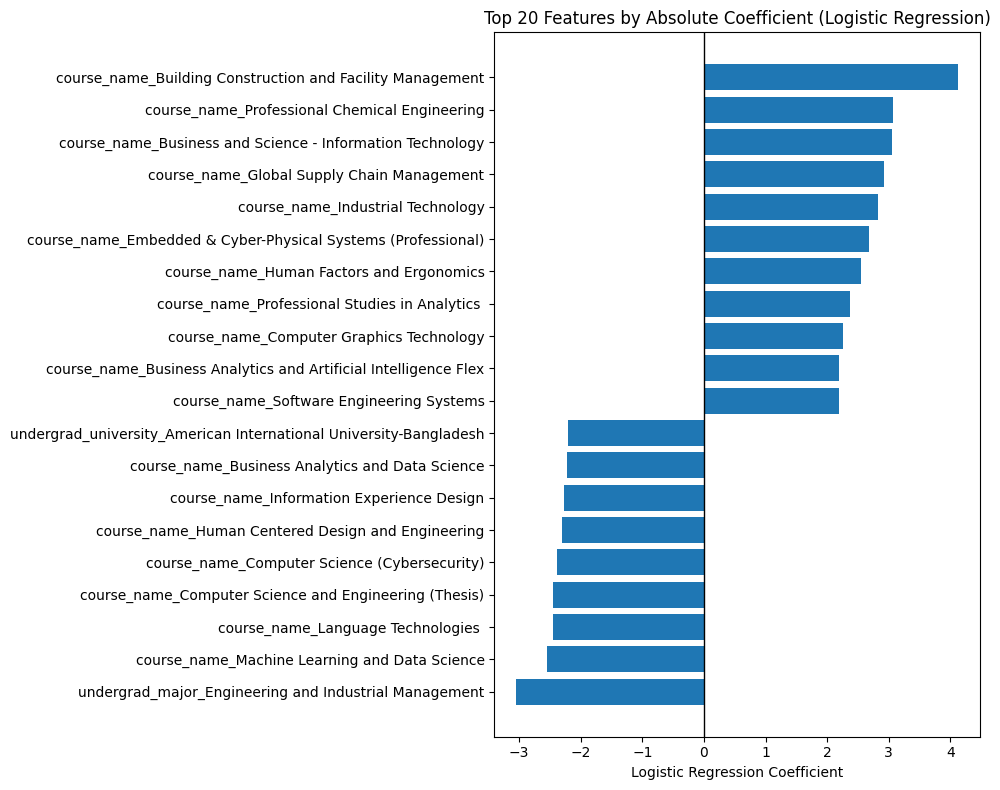

,feature,coef,odds_ratio
3401,undergrad_major_Engineering and Industrial Man...,-3.045488,0.047573
2336,course_name_Machine Learning and Data Science,-2.542112,0.078700
2310,course_name_Language Technologies,-2.453790,0.085967
1572,course_name_Computer Science and Engineering (...,-2.448758,0.086401
1543,course_name_Computer Science (Cybersecurity),-2.389251,0.091698
2088,course_name_Human Centered Design and Engineering,-2.298587,0.100401
2175,course_name_Information Experience Design,-2.270252,0.103286
1368,course_name_Business Analytics and Data Science,-2.218135,0.108812
4132,undergrad_university_American International Un...,-2.212485,0.109428
2720,course_name_Software Engineering Systems,2.197166,8.999475


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ohe = model.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])
coeffs = model.named_steps["log_reg"].coef_[0]
coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coeffs,
})
coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df["abs_coef"] = coef_df["coef"].abs()

top_n = 20
top = coef_df.sort_values("abs_coef", ascending=True).tail(top_n)
top = top.sort_values("coef")
plt.figure(figsize=(10, 8))
plt.barh(top["feature"], top["coef"])
plt.axvline(0, color="k", linewidth=1)

plt.xlabel("Logistic Regression Coefficient")
plt.title(f"Top {top_n} Features by Absolute Coefficient (Logistic Regression)")
plt.tight_layout()
plt.show()
display(top[["feature", "coef", "odds_ratio"]])
